In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [2]:
path = "https://raw.githubusercontent.com/DSEI21000-S21/project-tennis-ml/main/atp_matches/atp_matches-2000-2021_expanded.csv"
def readData(path):
    df = pd.read_csv(path)
    return df

def dropGibberishRows(dataframe, column_name, filter_variable):
    index_list = list(dataframe[dataframe[column_name] == filter_variable].index)
    dataframe = dataframe.drop(index_list)
    return dataframe

#def encodeColumn(dataframe, column_list = []):
    #df = pd.get_dummies(dataframe, columns= column_list)
    #return df

def convertDate(dataframe, date):
    dataframe[date] = pd.to_datetime(dataframe[date], format = '%Y%m%d', errors='coerce')
    return dataframe

def addDateFeatures(dataframe, date):
    dataframe['year'] = dataframe[date].dt.year
    dataframe['month'] = dataframe[date].dt.month
    dataframe['day'] = dataframe[date].dt.day
    return dataframe

def appendTarget(dataframe, winner, loser):
    dataframe[winner] = 1
    dataframe[loser] = 0
    return dataframe

def getMissingDataPercentage(dataframe):
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                 'percent_missing': percent_missing})
    pd.set_option("max_rows", None)
    return missing_value_df

def formatColumns(dataframe):
    columns = list(dataframe.columns)
    renamed_columns = [i.lower().strip().replace(' ', "_").replace(':','') for i in columns]
    renamed_columns_dict = {columns[i]: renamed_columns[i] for i in range(len(columns))}
    dataframe = dataframe.rename(columns = renamed_columns_dict)
    return dataframe

def convertColumnsToNumeric(dataframe, columns = []):
    dataframe[columns] = dataframe[columns].apply(pd.to_numeric, errors ='coerce')
    return dataframe 

def fillMissingDataMode(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mode().iloc[0])
    return dataframe

def dropColumn(dataframe, column_list = []):
    return dataframe.drop(column_list, axis =1)

def fillMissingDataMean(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mean().iloc[0])
    return dataframe

def fillMissingData999(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(999)
    return dataframe

In [3]:
wta_data = readData(path)
wta_data = dropColumn(wta_data, ['player_entry', 'tourney_name'])
wta_data = fillMissingDataMode(wta_data, ['surface', 'player_hand'])
wta_data = fillMissingDataMean(wta_data, ['player_height', 'player_age', 'minutes', 'ace', 'double_fault', 'service_points_won', 'first_serve_made', 'first_serve_won', 
'second_serve_won', 'serve_game', 'break_point_saved', 'break_point_faced', 'player_rank','player_rank_points'])
wta_data = fillMissingData999(wta_data, ['player_seed'])
wta_data = convertDate(wta_data, 'tourney_date')
wta_data = addDateFeatures(wta_data, 'tourney_date')
wta_data = dropColumn(wta_data, ['player_ioc', 'score', 'tourney_id', 'tourney_date', 'player_name'])
#wta_data = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data = formatColumns(wta_data)

In [4]:
getMissingDataPercentage(wta_data)

,column_name,percent_missing
surface,surface,0.0
draw_size,draw_size,0.0
tourney_level,tourney_level,0.0
match_num,match_num,0.0
player_id,player_id,0.0
player_seed,player_seed,0.0
player_hand,player_hand,0.0
player_height,player_height,0.0
player_age,player_age,0.0
best_of,best_of,0.0


In [5]:
wta_data.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128070 entries, 0 to 128069
Data columns (total 27 columns):
surface               128070 non-null object
draw_size             128070 non-null int64
tourney_level         128070 non-null object
match_num             128070 non-null int64
player_id             128070 non-null int64
player_seed           128070 non-null float64
player_hand           128070 non-null object
player_height         128070 non-null float64
player_age            128070 non-null float64
best_of               128070 non-null int64
round                 128070 non-null object
minutes               128070 non-null float64
ace                   128070 non-null float64
double_fault          128070 non-null float64
service_points_won    128070 non-null float64
first_serve_made      128070 non-null float64
first_serve_won       128070 non-null float64
second_serve_won      128070 non-null float64
serve_game            128070 non-null float64
break_point_saved     12807

In [6]:
wta_data.describe()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
count,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,...,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000,128070.000000
mean,54.295932,78.659202,105708.957445,681.098228,185.490424,26.353030,3.464777,114.749293,22.810784,20.109738,...,31.738285,28.596136,21.105888,23.566847,100.991128,1234.587216,0.500000,2009.599578,5.504052,16.039135
std,39.472986,124.849842,10142.957321,462.642477,6.454959,4.591264,0.844714,46.330934,52.540061,53.216963,...,49.897418,50.598304,52.936055,52.228111,166.708211,1631.940928,0.500002,6.032364,2.968706,8.505676
min,4.000000,1.000000,100644.000000,1.000000,163.000000,14.513347,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000
25%,32.000000,10.000000,103344.000000,11.000000,183.000000,23.411362,3.000000,79.000000,2.000000,1.000000,...,11.000000,10.000000,2.000000,4.000000,26.000000,463.000000,0.000000,2004.000000,3.000000,9.000000
50%,32.000000,25.000000,104214.000000,999.000000,185.000000,26.195756,3.000000,105.000000,5.000000,3.000000,...,16.000000,12.000000,4.000000,7.000000,57.000000,775.000000,0.500000,2009.000000,5.000000,16.000000
75%,64.000000,87.000000,105023.000000,999.000000,188.000000,29.051335,3.000000,144.000000,10.000000,5.000000,...,22.000000,16.000000,7.000000,11.000000,103.000000,1315.000000,1.000000,2015.000000,8.000000,23.000000
max,128.000000,1701.000000,210013.000000,999.000000,208.000000,185.490424,5.000000,1266.000000,185.490424,185.490424,...,185.490424,185.490424,185.490424,185.490424,2159.000000,16950.000000,1.000000,2021.000000,12.000000,31.000000


In [7]:
wta_data.head()

,surface,draw_size,tourney_level,match_num,player_id,player_seed,player_hand,player_height,player_age,best_of,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
0,Hard,32,A,1,103163,1.0,R,188.0,21.771389,3,...,28.0,17.0,3.0,5.0,11.0,1612.0,1,2000,1,10
1,Hard,32,A,2,102607,999.0,R,190.0,24.558522,3,...,13.0,12.0,5.0,6.0,211.0,157.0,1,2000,1,10
2,Hard,32,A,3,103252,999.0,R,175.0,21.390828,3,...,12.0,8.0,1.0,1.0,48.0,726.0,1,2000,1,10
3,Hard,32,A,4,103507,7.0,R,183.0,19.909651,3,...,15.0,10.0,0.0,0.0,45.0,768.0,1,2000,1,10
4,Hard,32,A,5,102103,999.0,R,180.0,27.381246,3,...,14.0,13.0,6.0,11.0,167.0,219.0,1,2000,1,10


**check for missing values**

In [8]:
#Total missing values
wta_data.isnull().sum().sum()

0

In [9]:
# Random Seed
SEED = 42
np.random.seed = SEED

**check if the data is balance**     
target is our target variable, we want to make sure the data is balanced

In [10]:
#check if the data is balance
wta_data['target'].value_counts()

1    64035
0    64035
Name: target, dtype: int64

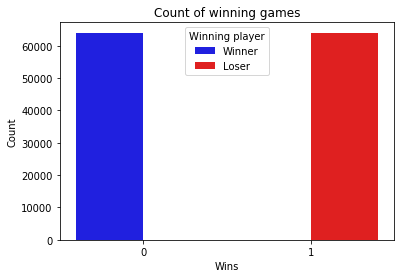

In [11]:
ax = sns.countplot(wta_data['target'], hue=wta_data['target'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning player', loc='upper center', labels=['Winner', 'Loser'])
ax.set_title('Count of winning games')
plt.show()

**Checking correlation between features**

In [12]:
wta_data_corr = wta_data.corr()
wta_data_corr['target'].sort_values(ascending=False)

target                1.000000e+00
player_rank_points    1.917371e-01
first_serve_won       3.836224e-02
player_height         3.173149e-02
ace                   1.563434e-02
second_serve_won      1.541906e-02
serve_game            1.840404e-03
match_num             2.772944e-18
year                  2.354490e-18
best_of               4.761817e-19
day                  -3.750624e-19
month                -1.051235e-18
draw_size            -1.176440e-18
minutes              -1.281319e-18
first_serve_made     -6.012039e-03
double_fault         -6.221288e-03
player_age           -8.406350e-03
player_id            -1.088801e-02
break_point_saved    -1.120556e-02
break_point_faced    -3.117033e-02
service_points_won   -3.314707e-02
player_rank          -1.175945e-01
player_seed          -2.019821e-01
Name: target, dtype: float64

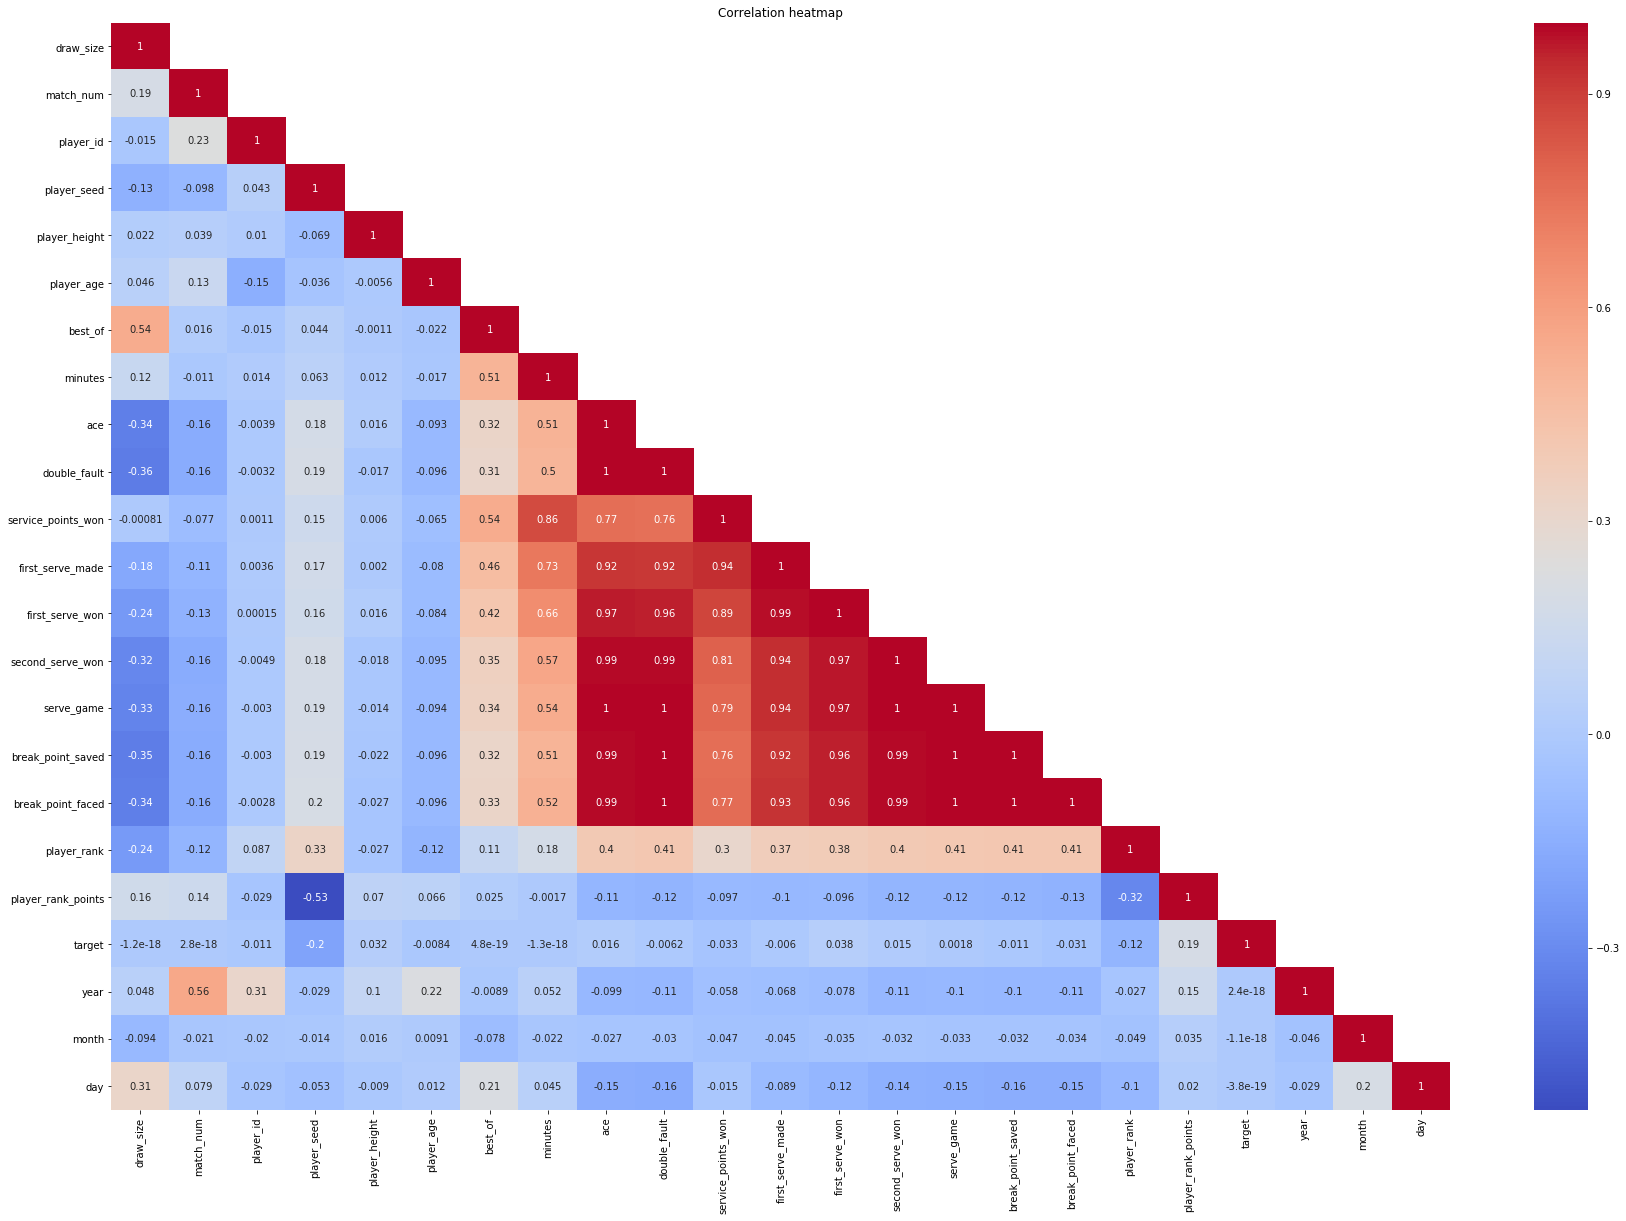

In [13]:
f, ax = plt.subplots(figsize= (30, 20))
lower = wta_data_corr.where(np.tril(np.ones(wta_data_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

**player_rank_points** is the highest positively correlated variable to the target variabl whereas **player_seed** is the negatively correlated to the target variable. 

**Convert the categorical columns to numeric**

In [14]:
def encodeColumn(dataframe, column_list = []):
    df = pd.get_dummies(dataframe, columns= column_list)
    return df

In [15]:
wta_data_numerical = encodeColumn(wta_data, ['surface', 'tourney_level', 'player_hand','round'])
wta_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128070 entries, 0 to 128069
Data columns (total 45 columns):
draw_size             128070 non-null int64
match_num             128070 non-null int64
player_id             128070 non-null int64
player_seed           128070 non-null float64
player_height         128070 non-null float64
player_age            128070 non-null float64
best_of               128070 non-null int64
minutes               128070 non-null float64
ace                   128070 non-null float64
double_fault          128070 non-null float64
service_points_won    128070 non-null float64
first_serve_made      128070 non-null float64
first_serve_won       128070 non-null float64
second_serve_won      128070 non-null float64
serve_game            128070 non-null float64
break_point_saved     128070 non-null float64
break_point_faced     128070 non-null float64
player_rank           128070 non-null float64
player_rank_points    128070 non-null float64
target                1

In [16]:
reduced_df = wta_data_numerical[(wta_data_numerical['year']== 2018 & 2019)]
reduced_df.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,round_BR,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
56004,32,271,105992,999.0,183.000000,25.653662,3,123.0,9.0,2.0,...,0,0,0,0,0,0,1,0,0,0
56005,32,272,111577,999.0,185.490424,21.229295,3,90.0,5.0,3.0,...,0,0,0,0,0,0,1,0,0,0
56006,32,273,104797,999.0,188.000000,31.318275,3,145.0,7.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56007,32,275,200282,999.0,185.490424,18.872005,3,104.0,9.0,3.0,...,0,0,0,0,0,0,1,0,0,0
56008,32,276,111581,999.0,185.490424,19.975359,3,69.0,5.0,4.0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
reduced_df = formatColumns(reduced_df)

In [18]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5948 entries, 56004 to 123012
Data columns (total 45 columns):
draw_size             5948 non-null int64
match_num             5948 non-null int64
player_id             5948 non-null int64
player_seed           5948 non-null float64
player_height         5948 non-null float64
player_age            5948 non-null float64
best_of               5948 non-null int64
minutes               5948 non-null float64
ace                   5948 non-null float64
double_fault          5948 non-null float64
service_points_won    5948 non-null float64
first_serve_made      5948 non-null float64
first_serve_won       5948 non-null float64
second_serve_won      5948 non-null float64
serve_game            5948 non-null float64
break_point_saved     5948 non-null float64
break_point_faced     5948 non-null float64
player_rank           5948 non-null float64
player_rank_points    5948 non-null float64
target                5948 non-null int64
year             

**Split data into training and testing sets**

In [19]:
X = reduced_df.loc[:, reduced_df.columns != 'target']
y = reduced_df['target']



**Methodology**

We will be doing feature scaling using standardization. We will then compare the models with and without features scaled. Except for decision trees and random forests.

**Split the data and Standardization**

In [20]:

#standardize both training and testing data
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=SEED)

**Apply the models on the Standardized Data**

**Logistic Regression**

In [28]:
lr = LogisticRegression()
lr_pipe = make_pipeline(lr)
lr_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_pipe.predict(X_std_train)
y_std_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.7955801104972375
Accuracy score on test: 0.807843137254902

f1 score on train: 0.7982934344631429
f1 score on test: 0.8112272977435333

Precision score on train: 0.788020589611605
Precision score on test: 0.7967567567567567

Recall score on train: 0.808837656099904
Recall score on test: 0.8262331838565022



C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Random Forest**

In [29]:
rf = RandomForestClassifier()
rf_pipe = make_pipeline(rf)
rf_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = rf_pipe.predict(X_std_train)
y_std_ts_pred = rf_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.9906317559452318
Accuracy score on test: 0.7064425770308124

f1 score on train: 0.9905956112852665
f1 score on test: 0.6946386946386947

Precision score on train: 0.9946731234866828
Precision score on test: 0.7233009708737864

Recall score on train: 0.9865513928914506
Recall score on test: 0.6681614349775785



C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Bagging classiefier**

In [35]:
bagged_config = dict(n_estimators=10, max_samples=0.6, max_features=0.7, random_state=42, n_jobs=-1)


clb = [lr_pipe, rf_pipe]
clb_names = ['LogisticRegression', 'Random Forest']

for name, cl in zip(clb_names, clb):
    
    bagcl = BaggingClassifier(cl, **bagged_config)
    
    stdsc = StandardScaler()

    #x_ts_sd = stdsc.fit_transform(X_test)

    y_tr_pred = lr_pipe.predict(X_std_train)
    y_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.7955801104972375
Accuracy score on test: 0.807843137254902

f1 score on train: 0.7982934344631429
f1 score on test: 0.8112272977435333

Precision score on train: 0.788020589611605
Precision score on test: 0.7967567567567567

Recall score on train: 0.808837656099904
Recall score on test: 0.8262331838565022



# GridSearchCV

**Logistic Regression**

In [30]:
lr = LogisticRegression(random_state= 42, C = 1)

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_cv.predict(X_std_train)
y_std_ts_pred = lr_cv.predict(X_std_test)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

{'C': 1.0}
0.7886139803026664


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
#accuracy score on the training set
accuracy_score(y_std_train, y_std_tr_pred) 

0.7955801104972375

# ANALYSIS

In [66]:
reduced_df_french = wta_data[(wta_data['year']== 2020) & (wta_data['tourney_name_roland_garros']==1)]
reduced_df_french.head()


,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,player_hand_u,round_br,round_f,round_qf,round_r128,round_r16,round_r32,round_r64,round_rr,round_sf
58441,128,2101,201594,1.0,168.000000,29.004791,3,82.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
58442,128,2102,201593,999.0,181.000000,30.091718,3,150.0,1.0,3.0,...,0,0,0,0,1,0,0,0,0,0
58443,128,2103,211095,999.0,173.385424,25.820671,3,86.0,2.0,9.0,...,0,0,0,0,1,0,0,0,0,0
58444,128,2104,216153,25.0,173.385424,19.077344,3,59.0,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0
58445,128,2105,201611,999.0,173.385424,26.568104,3,89.0,1.0,4.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
X_20 = reduced_df_french.loc[:, reduced_df_french.columns != 'target']
y_20 = reduced_df_french['target']

In [68]:
X_20_pred = lr_cv.predict(X_20 )

accuracy_score(y_20, X_20_pred)

0.5

In [81]:
#dt_pipe
X_20_pred_dt = dt_pipe.predict(X_20 )

accuracy_score(y_20, X_20_pred)

0.5

In [82]:
X_20_pred_dt

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [83]:
 np.unique(X_20_pred_dt)

array([0, 1], dtype=int64)

In [84]:
len(X_20_pred)

254

In [85]:
#add a column to X_20_pred
reduced_df_french['predicted_values']=X_20_pred

C:\Users\JAH\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Dataset with the predicted column**

In [87]:
reduced_df_french.to_pickle("C:/Users/JAH/Documents/DSE/DSE2100_ML_project_dataset.pkl")

In [88]:
reduced_df_french.to_csv("C:/Users/JAH/Documents/DSE/DSE2100_ML_project_dataset.csv")